In [1]:
%matplotlib inline
import sys
sys.path.append('../')
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torch.backends.cudnn as cudnn
import torch.optim.lr_scheduler as lr_scheduler

import torchvision
import torchvision.transforms as transforms

import os
import argparse
import time

from lib import models
from lib import datasets
import math

import numpy as np
import scipy as sp
import scipy.sparse.linalg as linalg
import scipy.sparse as sparse

import matplotlib.pyplot as plt
import easydict as edict

In [2]:
# parameters
args = edict

# cifar10 instance
args.resume = '../checkpoint/pretrain_models/ckpt_instance_cifar10_wrn-28-2_82.12.pth.tar'
args.cache = '../checkpoint/train_features_labels_cache/instance_wrn-28-2.pth.tar'
args.save_path = '../checkpoint/pseudos/instance_nc_wrn-28-2'

# imagenet instance
# args.resume = '../checkpoint/pretrain_models/ckpt_imagenet32x32_instance_wrn-28-2.pth.tar'
# args.cache = '../checkpoint/train_features_labels_cache/imagenet32x32_instance_pretrain_cifar10_feature_wrn-28-2.pth.tar'
# args.save_path = '../checkpoint/pseudos/imagenet32x32_instance_nc_wrn-28-2'

# imagenet snca
# args.resume = '../checkpoint/pretrain_models/ckpt_imagenet32x32_snca_wrn-28-2.pth.tar'
# args.cache = '../checkpoint/train_features_labels_cache/imagenet32x32_snca_pretrain_cifar10_feature_wrn-28-2.pth.tar'
# args.save_path = '../checkpoint/pseudos/imagenet32x32_snca_nc_wrn-28-2'

# imagenet softmax
# args.resume = '../checkpoint/pretrain_models/ckpt_imagenet32x32_softmax_wrn-28-2.pth.tar'
# args.cache = '../checkpoint/train_features_labels_cache/imagenet32x32_softmax_pretrain_cifar10_feature_wrn-28-2.pth.tar'
# args.save_path = '../checkpoint/pseudos/imagenet32x32_softmax_nc_wrn-28-2'


args.low_dim = 128
args.num_class = 10
args.rng_seed = 0

In [3]:
os.environ["CUDA_VISIBLE_DEVICES"] = '2'
device = 'cuda' if torch.cuda.is_available() else 'cpu'
os.makedirs(args.save_path, exist_ok=True)
os.makedirs('../checkpoint/train_features_labels_cache', exist_ok=True)
print(device)

cuda


In [4]:
# Data
print('==> Preparing data..')
transform_test = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2470, 0.2435, 0.2616)),
])

trainset = datasets.CIFAR10Instance(root='../data', train=True, download=True, transform=transform_test)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=128, shuffle=False, num_workers=2)

testset = datasets.CIFAR10Instance(root='../data', train=False, download=True, transform=transform_test)
testloader = torch.utils.data.DataLoader(testset, batch_size=100, shuffle=False, num_workers=2)

==> Preparing data..
Files already downloaded and verified
Files already downloaded and verified


In [5]:
# checkpoint = torch.load(args.resume)
# checkpoint.keys()

# checkpoint['net'] = checkpoint.pop('state_dict')
# torch.save(checkpoint, args.resume)

In [6]:
print('==> get train features and labels..')
if os.path.isfile(args.cache):
    ckpt = torch.load(args.cache)
    train_labels, train_features = ckpt['train_labels'], ckpt['train_features']
else:
    checkpoint = torch.load(args.resume)
    net = models.WideResNet(depth=28, num_classes=128, widen_factor=2, dropRate=0, norm=True).to(device)
    net = torch.nn.DataParallel(net, device_ids=range(torch.cuda.device_count()))
    cudnn.benchmark = True
    model_dict = net.state_dict()
    pretrained_dict = {k: v for k, v in checkpoint['net'].items()
                       if k in model_dict and v.size() == model_dict[k].size()}
    assert len(pretrained_dict) > 0
    model_dict.update(pretrained_dict)
    net.load_state_dict(model_dict)
    net = net.module.to(device)

    train_labels = -1 * torch.ones([len(trainloader.dataset)], dtype=torch.long).to(device)
    train_features = torch.zeros([len(trainloader.dataset), 128], dtype=torch.float32).to(device)

    with torch.no_grad():
        for i, (data, label, index) in enumerate(trainloader):
            train_labels[index] = label.to(device)
            train_features[index] = net(data.to(device))

            if i % 50 == 0:
                print("{}/{}".format(i, len(trainloader)))

    
    save_dict = {
        'train_features': train_features,
        'train_labels': train_labels,
    }
    torch.save(save_dict, args.cache)
print(train_features.shape, train_labels.shape)

==> get train features and labels..


/home/liubin/anaconda3/envs/py36/lib/python3.6/site-packages/torch/serialization.py:454: SourceChangeWarning: source code of class 'lib.LinearAverage.LinearAverage' has changed. you can retrieve the original source code by accessing the object's source attribute or set `torch.nn.Module.dump_patches = True` and use the patch tool to revert the changes.
  warnings.warn(msg, SourceChangeWarning)


0/391
50/391
100/391
150/391
200/391
250/391
300/391
350/391
torch.Size([50000, 128]) torch.Size([50000])


# use cpu because the follow computation need a lot of memory

In [7]:
device = 'cpu'
train_features, train_labels = train_features.to(device), train_labels.to(device)

In [8]:
num_train_data = train_labels.shape[0]
num_class = torch.max(train_labels) + 1

torch.manual_seed(args.rng_seed)
torch.cuda.manual_seed_all(args.rng_seed)
perm = torch.randperm(num_train_data).to(device)
print(perm)

tensor([36044, 49165, 37807,  ..., 42128, 15898, 31476])


# constrained normalized cut

In [9]:
K = 100
K = 20
start = time.time()
def make_column_normalize(X):
    return X.div(torch.norm(X, p=2, dim=0, keepdim=True))

cosin_similarity = torch.mm(train_features, train_features.t())
dist = (1 - cosin_similarity) / 2
n = dist.size(0)

dist_sorted, idx = dist.topk(K, dim=1, largest=False, sorted=True)
k_dist = dist_sorted[:, -1:]

similarity_sorted = torch.exp(-dist_sorted * 2 / 0.2)

# build the sparse similarity matrix
from scipy import sparse
col = idx.numpy().flatten()
row = np.tile(np.linspace(0,n-1,n,dtype=np.int64).reshape(-1,1),(1,K)).flatten()
data = similarity_sorted.numpy().flatten()
similarity_sparse = sparse.bsr_matrix((data, (row, col)), shape=(n,n))

similarity_sparse = (similarity_sparse + similarity_sparse.T) / 2.
print('similarity done')

degree = torch.from_numpy(np.sum(similarity_sparse, axis=0)).float()
#degree_normed = 1. / np.sqrt(degree)
#L_sys = np.diag(degree_normed) * (np.diag(degree) - similarity_sparse) * np.diag(degree_normed)
from scipy.sparse import csgraph
L_sys = csgraph.laplacian(similarity_sparse, normed=True)
print('L_sys done')
print(time.time() - start)

similarity done
L_sys done
29.704587697982788


In [10]:
num_eigenvectors = 200 # the number of precomputed spectral eigenvectors.

from scipy import sparse
L_sparse = L_sys
start = time.time()
eigenvalues, eigenvectors = linalg.eigsh(L_sparse, k=num_eigenvectors, which='SM', tol=1e-2, maxiter=30000)
eigenvalues = eigenvalues.astype(np.float32)
eigenvectors = eigenvectors.astype(np.float32)
eigenvalues, eigenvectors = torch.from_numpy(eigenvalues.real)[1:], torch.from_numpy(eigenvectors.real)[:, 1:]
eigenvalues, idx = eigenvalues.sort()
eigenvectors = eigenvectors[:, idx]
print('eigenvectors done')
print(eigenvalues)
print(time.time() - start)

eigenvectors done
tensor([0.0164, 0.0270, 0.0395, 0.0498, 0.0515, 0.0602, 0.0708, 0.0723, 0.0735,
        0.0860, 0.0945, 0.0956, 0.0984, 0.0992, 0.1050, 0.1070, 0.1082, 0.1108,
        0.1152, 0.1184, 0.1217, 0.1266, 0.1291, 0.1312, 0.1340, 0.1358, 0.1382,
        0.1447, 0.1452, 0.1463, 0.1469, 0.1486, 0.1505, 0.1538, 0.1548, 0.1580,
        0.1598, 0.1615, 0.1627, 0.1643, 0.1679, 0.1690, 0.1697, 0.1713, 0.1753,
        0.1761, 0.1767, 0.1784, 0.1802, 0.1827, 0.1847, 0.1849, 0.1856, 0.1870,
        0.1878, 0.1893, 0.1898, 0.1921, 0.1936, 0.1951, 0.1956, 0.1972, 0.1983,
        0.2002, 0.2014, 0.2021, 0.2037, 0.2047, 0.2051, 0.2079, 0.2083, 0.2112,
        0.2116, 0.2122, 0.2127, 0.2139, 0.2157, 0.2163, 0.2168, 0.2174, 0.2187,
        0.2199, 0.2209, 0.2229, 0.2241, 0.2245, 0.2259, 0.2268, 0.2273, 0.2281,
        0.2289, 0.2303, 0.2306, 0.2316, 0.2323, 0.2335, 0.2343, 0.2352, 0.2356,
        0.2364, 0.2387, 0.2391, 0.2404, 0.2411, 0.2419, 0.2426, 0.2432, 0.2442,
        0.2449, 0.2456

tensor([24681, 42151, 48978, 41040, 36909,  8628, 24936, 35926, 15934,  8801,
        36293, 28026,  3814, 34981, 21135, 16904, 20152,  3486, 11894, 29780,
        23932, 33744, 41766, 42979, 49518, 11341,  6091, 48161, 36335, 29858,
        36044, 25569, 46340,  8832, 38677, 37807,  4480, 18517,  8409, 15769,
        49165, 43846, 13449, 34615, 38862, 17849, 49031,  4115, 29909, 34515])
num_labeled=  50 T_nc=1, prec=58.29, AUC=75.12
tensor([24681, 42151, 48978, 41040, 36909, 10197, 38770, 40649, 43279, 27934,
         8628, 24936, 35926, 15934,  8801, 27814, 37390, 12841, 22270, 10107,
        36293, 28026,  3814, 34981, 21135, 46451, 48404,  8366, 32477, 48870,
        16904, 20152,  3486, 11894, 29780, 47462, 34297,  1271, 28738, 12147,
        23932, 33744, 41766, 42979, 49518, 18912, 32018, 17323,  1974, 27259,
        11341,  6091, 48161, 36335, 29858, 17315, 22879, 43307, 23185, 10318,
        36044, 25569, 46340,  8832, 38677, 36881, 11751,  9278,  1836,  8557,
        37807,  

num_labeled=1000 T_nc=1, prec=74.20, AUC=90.53
tensor([24681, 42151, 48978,  ..., 45996,  2547, 42591])
num_labeled=2000 T_nc=1, prec=74.56, AUC=90.74
tensor([24681, 42151, 48978,  ..., 24162,  7571, 27527])
num_labeled=4000 T_nc=1, prec=75.15, AUC=90.95
tensor([24681, 42151, 48978,  ..., 20354, 29514, 21350])
num_labeled=8000 T_nc=1, prec=75.24, AUC=91.15


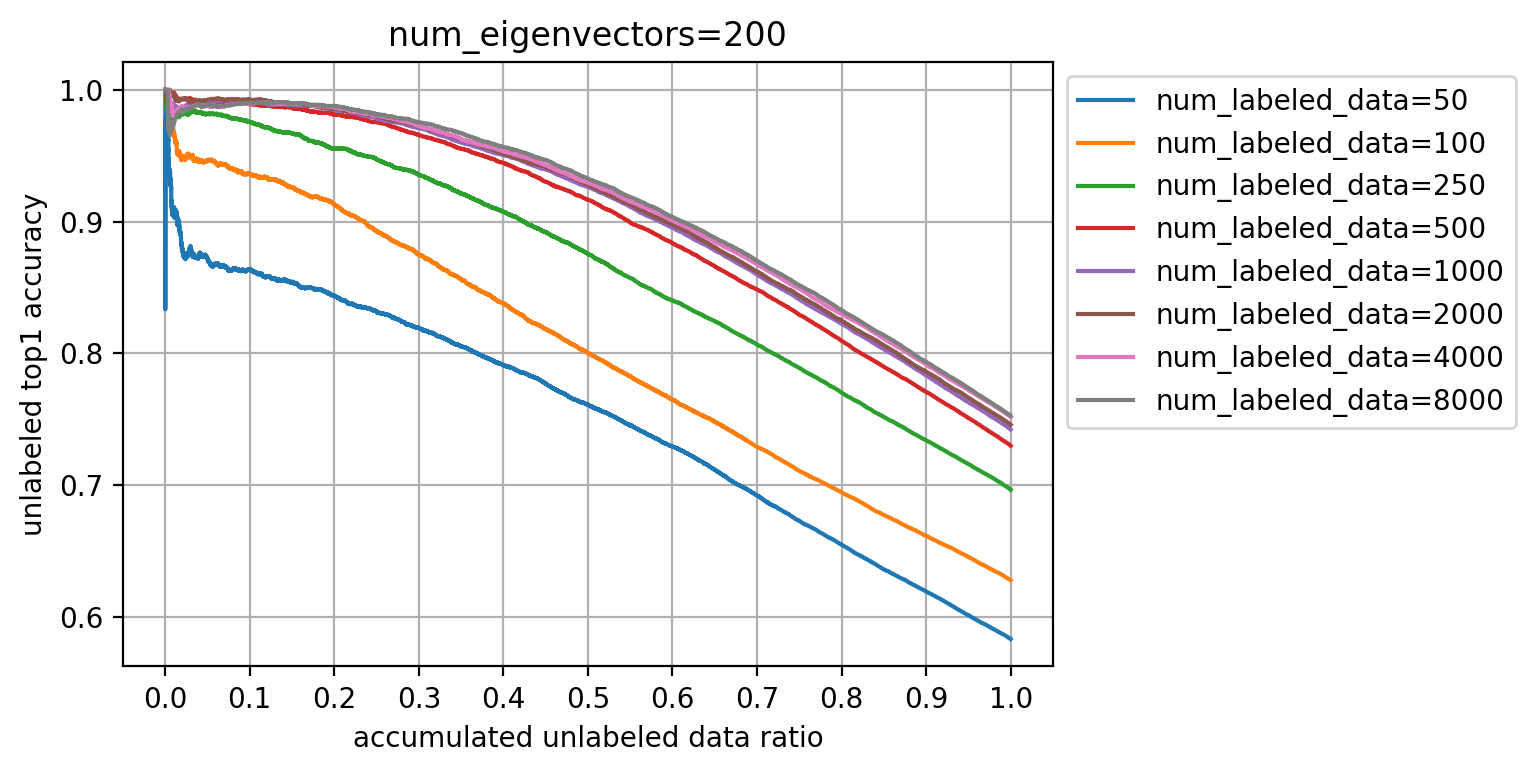

In [14]:
fig = plt.figure(dpi=200)

for num_labeled_data in [50, 100, 250, 500, 1000, 2000, 4000, 8000]:
    # index of labeled and unlabeled
    # even split
    index_labeled = []
    index_unlabeled = []
    data_per_class = num_labeled_data // args.num_class
    for c in range(10):
        indexes_c = perm[train_labels[perm] == c]
        index_labeled.append(indexes_c[:data_per_class])
        index_unlabeled.append(indexes_c[data_per_class:])
    index_labeled = torch.cat(index_labeled)
    index_unlabeled = torch.cat(index_unlabeled)

#     index_labeled = perm[:num_labeled_data]
#     index_unlabeled = perm[num_labeled_data:]
    
    # prior
    unary_prior = torch.zeros([num_train_data, num_class]).float()
    unary_prior[index_labeled, :] = -1
    unary_prior[index_labeled, train_labels[index_labeled]] = 1
    AQ = unary_prior.abs()
    pd = degree.view(-1, 1) * (AQ + unary_prior) / 2
    nd = degree.view(-1, 1) * (AQ - unary_prior) / 2
    np_ratio = pd.sum(dim=0) / nd.sum(dim=0)
    unary_prior_norm = (pd / np_ratio).sqrt() - (nd * np_ratio).sqrt()
    unary_prior_norm = make_column_normalize(unary_prior_norm)
    
    # logits and prediction
    alpha = 0
    lambda_reverse = (1 / (eigenvalues - alpha)).view(1, -1)
    logits = torch.mm(lambda_reverse * eigenvectors, torch.mm(eigenvectors.t(), unary_prior_norm))
    logits = make_column_normalize(logits) * math.sqrt(logits.shape[0])   
    logits = logits - logits.max(1, keepdim=True)[0]
    _, predict = logits.max(dim=1)
    
    temperature_nc = 1
    
    # pseudo weights
    logits_sorted = logits.sort(dim=1, descending=True)[0]
    subtract = logits_sorted[:, 0] - logits_sorted[:, 1]
    pseudo_weights = 1 - torch.exp(- subtract / temperature_nc)

    exp = (logits * temperature_nc).exp()
    probs = exp / exp.sum(1, keepdim=True)
    probs_sorted, predict_all = probs.sort(1, True)
    assert torch.all(predict == predict_all[:, 0])

    idx = pseudo_weights[index_unlabeled].sort(dim=0, descending=True)[1]
    pseudo_indexes = index_unlabeled[idx]
    pseudo_labels = predict[index_unlabeled][idx]
    pseudo_probs = probs[index_unlabeled][idx]
    pseudo_weights = pseudo_weights[index_unlabeled][idx]
    assert torch.all(pseudo_labels == pseudo_probs.max(1)[1])

    save_dict = {
        'pseudo_indexes': pseudo_indexes,
        'pseudo_labels': pseudo_labels,
        'pseudo_probs': pseudo_probs,
        'pseudo_weights': pseudo_weights,
        'labeled_indexes': index_labeled,
        'unlabeled_indexes': index_unlabeled,
    }
    torch.save(save_dict, os.path.join(args.save_path, f'{num_labeled_data}.pth.tar'))

    # for plot
    correct = pseudo_labels == train_labels[pseudo_indexes]

    entropy = - (pseudo_probs * torch.log(pseudo_probs + 1e-7)).sum(dim=1)
    confidence = (- entropy * 1).exp()
    confidence /= confidence.max()

    arange = 1 + np.arange(confidence.shape[0])
    xs = arange / confidence.shape[0]
    correct_tmp = correct[confidence.sort(descending=True)[1]]
    accuracies = np.cumsum(correct_tmp.numpy()) / arange
    plt.plot(xs, accuracies, label='num_labeled_data={}'.format(num_labeled_data))

    acc = correct.float().mean()

    print('num_labeled={:4} T_nc={}, prec={:.2f}, AUC={:.2f}'.format(
        num_labeled_data, temperature_nc, acc * 100, accuracies.mean() * 100))
        
plt.xlabel('accumulated unlabeled data ratio')
plt.ylabel('unlabeled top1 accuracy')
plt.xticks(np.arange(0, 1.01, 0.1))
plt.grid()
plt.title('num_eigenvectors={}'.format(num_eigenvectors))
legend = plt.legend(loc='upper left', bbox_to_anchor=(1, 1))
plt.show()

# matrix visulization

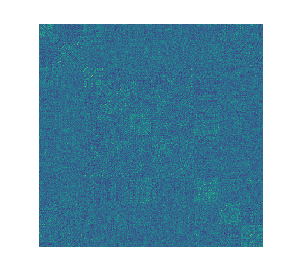

In [12]:
num_to_show = 2000
index_to_show = torch.randperm(50000)[:num_to_show]
# dist_sorted, idx = dist.topk(K, dim=1, largest=False, sorted=True)
# index_to_show = torch.Tensor(list(set(idx[:, 1].numpy()))).long()[:num_to_show]

index_to_show = torch.Tensor(sorted(index_to_show.numpy(), key=lambda index: train_labels[index].item())).long()

tmp = cosin_similarity[index_to_show, :][:, index_to_show].clone()
tmp[torch.arange(num_to_show), torch.arange(num_to_show)] = 0
plt.matshow(tmp)
plt.axis('off')
# plt.savefig('cosine_similarity.pdf')
plt.show()

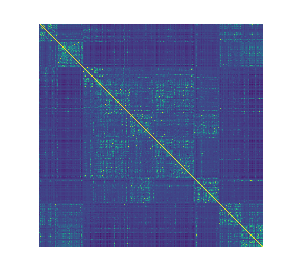

In [13]:
tmp1 = eigenvectors * torch.sqrt(lambda_reverse)
eigenvectors_normed = tmp1 / torch.norm(tmp1, dim=1).reshape(-1, 1)
plt.matshow((torch.mm(eigenvectors_normed, eigenvectors_normed.t()))[index_to_show, :][:, index_to_show])
plt.axis('off')
# plt.savefig('nc.pdf')
plt.show()